In [1]:
import sys
sys.path.append('..')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd
import graph_tool as gt
from tqdm import tqdm
from operator import itemgetter
from functools import reduce
import itertools
import scipy.sparse as sps
import random
import os
#from pymnet import *

import MuxVizPy as mxp

import gseapy as gp

import warnings
warnings.filterwarnings("ignore")


#set.seed(1)

# input data settings
NEIGH_ORDER = 1 # or 0, order of nerighbors, 0 only connected proteins, 1 also first neighbors
CUT_THR = 0.7   # don't change this one

target_folder = "../Data/Virus_data_Enriched_"+str(CUT_THR)+"_Neigh_"+str(NEIGH_ORDER)+"/"

# multilayer settings
layerCouplingStrength = 1
networkOfLayersType = "categorical" ## = all to all

#virus metadata
virus_metadata = pd.read_csv("../Data/Files/viruses_metadata.csv", header=0, sep=";")

virus_metadata_onco = virus_metadata[virus_metadata["isOncogenic"] == True].reset_index()
virus_metadata_nonco = virus_metadata[virus_metadata["isOncogenic"] == False].reset_index()

#dictionary containing a unquie mapping between name of the protein and a corresponding index
node_map_df = pd.read_csv("../Data/Files/node_map.csv")
node_map_dict = {k:(v-1) for k,v in zip(node_map_df["Prot"], node_map_df["Index"])}

#function to create list of n_iter combination of nonco virus indexes with a fixed random seed for repitibility
def SamplingForNoco(n_iter, start=0, group_dim=8, random_seed=1234):
    np.random.seed(random_seed)
    nonco_cond = np.where(np.all([np.array(virus_metadata["virus"]!="Human_SARS_coronavirus_2"),
                                  np.array(virus_metadata["virus_short"]!="Lymphocytic_choriomeningitis_virus"),
                                  np.array(virus_metadata["neigh_order"]==NEIGH_ORDER), 
                                  np.array(virus_metadata["isOncogenic"]==False)],
                                  axis=0))
    
    nonco_sampling = np.array([np.random.choice(nonco_cond[0], group_dim, replace=False) for i in range(n_iter+start)])
    return nonco_sampling[start:(n_iter+start)]

# Components

In [20]:
o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/o_lcc.txt")
o_lic = np.loadtxt("../Data/ComponentsNew/LIC/o_lic.txt")
o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/o_lvc.txt")

n_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n_lcc.txt")
n_lic = np.loadtxt("../Data/ComponentsNew/LIC/n_lic.txt")
n_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n_lvc.txt")

n1o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n1o_lcc.txt")
n1o_lic = np.loadtxt("../Data/ComponentsNew/LIC/n1o_lic.txt")
n1o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n1o_lvc.txt")

n2o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n2o_lcc.txt")
n2o_lic = np.loadtxt("../Data/ComponentsNew/LIC/n2o_lic.txt")
n2o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n2o_lvc.txt")

n3o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n3o_lcc.txt")
n3o_lic = np.loadtxt("../Data/ComponentsNew/LIC/n3o_lic.txt")
n3o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n3o_lvc.txt")

n1o1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n1o1s_lcc.txt")
n1o1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/n1o1s_lic.txt")
n1o1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n1o1s_lvc.txt")

n2o1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n2o1s_lcc.txt")
n2o1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/n2o1s_lic.txt")
n2o1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n2o1s_lvc.txt")

n1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n1s_lcc.txt")
n1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/n1s_lic.txt")
n1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n1s_lvc.txt")

o1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/o1s_lcc.txt")
o1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/o1s_lic.txt")
o1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/o1s_lvc.txt")

In [ ]:
from matplotlib import cm

(0.0, 0.004)

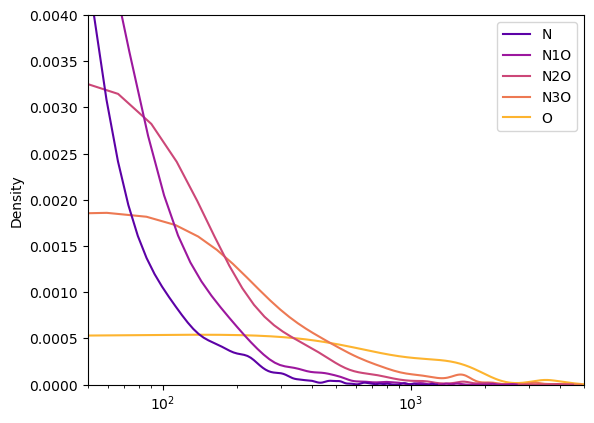

In [24]:
sns.kdeplot(dict({"N": n_lic+1, "N1O": n1o_lic+1, "N2O": n2o_lic+1,"N3O": n3o_lic+1,"O": o_lic+1}), 
            palette="plasma", common_norm=False)#hue=[cmap(i) for i in [0,0.2,0.4,0.6,0.8]])
plt.xscale("log")
plt.xlim([50,5000])
plt.ylim([0,0.004])

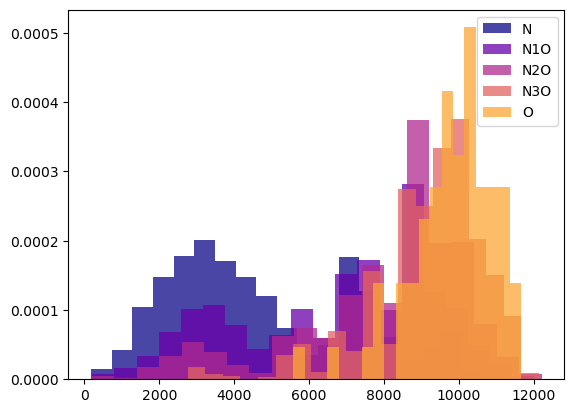

In [199]:
cmap = cm.get_cmap("plasma")

plt.hist(n_lcc, density=True, bins=20, alpha=0.75, color=cmap(0), label="N")
plt.hist(n1o_lcc, density=True, bins=20, alpha=0.75, color=cmap(0.2), label="N1O")
plt.hist(n2o_lcc, density=True, bins=20, alpha=0.75, color=cmap(0.4), label="N2O")
plt.hist(n3o_lcc, density=True, bins=20, alpha=0.75, color=cmap(0.6), label="N3O")
plt.hist(o_lcc, density=True, bins=20, alpha=0.75, color=cmap(0.8), label="O")

plt.legend()

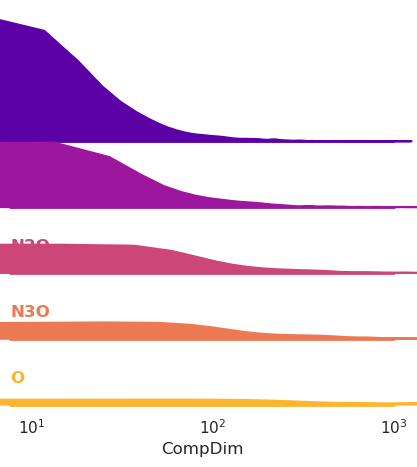

In [341]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = np.concatenate([["N"]*len(n_lic),
                    ["N1O"]*len(n1o_lic),
                    ["N2O"]*len(n2o_lic),
                    ["N3O"]*len(n3o_lic),
                    ["O"]*len(o_lic)])
                   
x = np.concatenate([n_lic, n1o_lic, n2o_lic, n3o_lic, o_lic])+1
df = pd.DataFrame(dict(CompDim=x, g=g))
pal = ["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette="plasma")
g.map(sns.kdeplot, "CompDim",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    #ax.vlines(len(onco_lcc), 0 ,0.0018, ls="--", color="red")
g.map(label, "CompDim")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xscale="log", xlim=[0,1000])
g.despine(bottom=True, left=True)

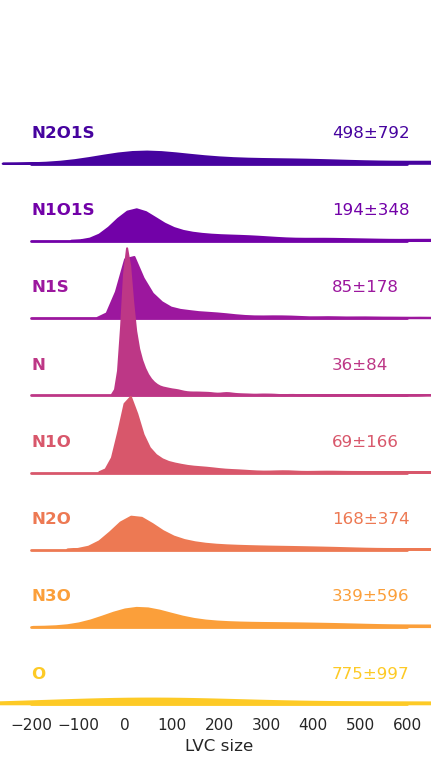

In [415]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

#data = [n2o1s_lcc, n1o1s_lcc, n1s_lcc, n_lcc, n1o_lcc, n2o_lcc, n3o_lcc, o_lcc]
#data = [n2o1s_lic, n1o1s_lic, n1s_lic, n_lic, n1o_lic, n2o_lic, n3o_lic, o_lic]
data = [n2o1s_lvc, n1o1s_lvc, n1s_lvc, n_lvc, n1o_lvc, n2o_lvc, n3o_lvc, o_lvc]
names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O"]
g = np.concatenate([[names[i]]*len(data[i]) for i in range(len(data))])

data_dict=dict(zip(names,data))
x = np.concatenate(data)
df = pd.DataFrame(dict(CompDim=x, g=g))
pal = ["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette="plasma")
g.map(sns.kdeplot, "CompDim",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(0.8, .2, "%d±%d"%(np.mean(data_dict[label]), np.std(data_dict[label])), color=color,
            ha="left", va="center", transform=ax.transAxes)
    #ax.vlines(len(onco_lcc), 0 ,0.0018, ls="--", color="red")
g.map(label, "CompDim")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="LVC size",xlim=[-200,600])
g.despine(bottom=True, left=True)

In [383]:
o_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/o.txt")
o_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/o.txt")

n_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n.txt")
n_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n.txt")

n1o_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n1o.txt")
n1o_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n1o.txt")

n2o_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n2o.txt")
n2o_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n2o.txt")

n3o_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n3o.txt")
n3o_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n3o.txt")

n1o1s_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n1o1s.txt")
n1o1s_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n1o1s.txt")

n2o1s_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n2o1s.txt")
n2o1s_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n2o1s.txt")

n1s_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n1s.txt")
n1s_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n1s.txt")

o1s_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/o1s.txt")
o1s_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/o1s.txt")

In [101]:
def find_itersection(prots, node_map = node_map_dict):
    inter = np.intersect1d(prots[0], prots[1])
    for i in tqdm(range(2, len(prots))):
        inter=np.intersect1d(inter, prots[i])
    if len(inter)!=0:
        return np.array(list(node_map.keys()))[inter]
    else:
        return []

In [103]:
o_lvc_inter = find_itersection(o_lvc_prot)
print((",").join(o_lic_inter.tolist()))

100%|█████████████████████████████████████████| 66/66 [00:00<00:00, 9458.57it/s]

RNF4,DAXX,PARP1,TP53,MDM2,CREBBP,ABL1,HMGA1,HIST2H2BE,PIN1,FBXW7,PML,TRIM25,MAP3K1,MDM4,UBE2I,NKX2-1,SMAD3,TP73,PPM1D,HNRNPL,KIAA1429,SMAD2,CTBP1,CBX4,ACTBL2,RANBP9,SUMO2,SKI,PIAS1


In [105]:
np.equal(o_lvc_inter,o_lic_inter)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [10]:
enr = gp.enrichr(gene_list="onco_core.txt", # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [20]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cell cycle,6/124,2.642907e-08,0.000002,0,0,42.059322,733.884750,SMAD2;CREBBP;SMAD3;MDM2;ABL1;TP53
1,KEGG_2021_Human,Ubiquitin mediated proteolysis,6/140,5.461717e-08,0.000002,0,0,37.007463,618.872750,UBE2I;MAP3K1;FBXW7;MDM2;PML;PIAS1
2,KEGG_2021_Human,p53 signaling pathway,5/73,7.480064e-08,0.000002,0,0,58.535294,960.472825,MDM2;MDM4;PPM1D;TP53;TP73
3,KEGG_2021_Human,Chronic myeloid leukemia,5/76,9.171669e-08,0.000002,0,0,56.053521,908.322729,SMAD3;CTBP1;MDM2;ABL1;TP53
4,KEGG_2021_Human,Pathways in cancer,8/531,8.189686e-07,0.000015,0,0,13.521293,189.503900,SMAD2;CREBBP;SMAD3;CTBP1;MDM2;ABL1;TP53;PML
...,...,...,...,...,...,...,...,...,...,...
84,KEGG_2021_Human,Pathogenic Escherichia coli infection,1/197,2.570904e-01,0.269189,0,0,3.478888,4.725469,ABL1
85,KEGG_2021_Human,Lipid and atherosclerosis,1/215,2.770982e-01,0.284590,0,0,3.183371,4.085485,TP53
86,KEGG_2021_Human,cAMP signaling pathway,1/216,2.781943e-01,0.284590,0,0,3.168404,4.053769,CREBBP
87,KEGG_2021_Human,Ras signaling pathway,1/232,2.955155e-01,0.298874,0,0,2.946559,3.591956,ABL1


In [36]:
print(enr.results.sort_values("Adjusted P-value")[["Term", "Overlap", "Adjusted P-value"]].head(15).to_latex(index=False))

\begin{tabular}{llr}
\toprule
                                   Term & Overlap &  Adjusted P-value \\
\midrule
                             Cell cycle &   6/124 &          0.000002 \\
         Ubiquitin mediated proteolysis &   6/140 &          0.000002 \\
                  p53 signaling pathway &    5/73 &          0.000002 \\
               Chronic myeloid leukemia &    5/76 &          0.000002 \\
                     Pathways in cancer &   8/531 &          0.000015 \\
                    MicroRNAs in cancer &   6/310 &          0.000085 \\
Human T-cell leukemia virus 1 infection &   5/219 &          0.000218 \\
         Neurotrophin signaling pathway &   4/119 &          0.000322 \\
                    Cellular senescence &   4/156 &          0.000824 \\
                  Wnt signaling pathway &   4/166 &          0.000858 \\
                            Hepatitis B &   4/162 &          0.000858 \\
  RIG-I-like receptor signaling pathway &    3/70 &          0.001155 \\
            

In [54]:
n_lic_inter = find_itersection(o1s_lvc_prot)
n_lic_inter

100%|█████████████████████████████████████████| 63/63 [00:00<00:00, 6981.64it/s]


array(['MDM2', 'TRIM25', 'TP73', 'PPM1D', 'CBX4', 'ACTBL2', 'SUMO2'],
      dtype='<U32')

In [72]:
np.all([np.all(n1o_lvc_prot[i] == n1o_lic_prot[i]) for i in range(2000)])

True

In [106]:
n_lic_un, n_lic_cnt = np.unique(np.concatenate(n_lic_prot[:2000]), return_counts=True)
n_lvc_un, n_lvc_cnt = np.unique(np.concatenate(n_lvc_prot[:2000]), return_counts=True)

n_lic_freq = pd.DataFrame({"Prot_ind": n_lic_un.astype(int), "Counts": n_lic_cnt}) 
n_lic_freq["Prot_name"] = np.array(list(node_map_dict.keys()))[n_lic_freq["Prot_ind"]]
n_lvc_freq = pd.DataFrame({"Prot_ind": n_lvc_un.astype(int), "Counts": n_lvc_cnt}) 
n_lvc_freq["Prot_name"] = np.array(list(node_map_dict.keys()))[n_lvc_freq["Prot_ind"]]

n_lvc_sorted = n_lvc_freq.sort_values("Counts", ascending=False)[["Prot_name", "Counts"]]
n_lic_dict = dict(zip(n_lic_sorted["Prot_name"], n_lic_sorted["Counts"]))

In [107]:
n_lvc_freq

,Prot_ind,Counts,Prot_name
0,0,47,PTGS2
1,1,61,CDK1
2,2,733,RELA
3,3,643,TNF
4,4,55,CYLD
...,...,...,...
3728,11083,1,USP20
3729,11126,2,TTI1
3730,11207,1,HPSE
3731,11346,1,SMO


In [108]:
n_lvc_freq["Counts_LIC"] = n_lvc_freq["Prot_name"].map(n_lic_dict)

In [109]:
n_lvc_freq[(n_lvc_freq["Counts_LIC"]-n_lvc_freq["Counts"])>10]

,Prot_ind,Counts,Prot_name,Counts_LIC
28,35,601,NTRK1,612
86,98,300,CDK9,313
157,174,406,HSP90AA1,443


In [118]:
top_res = n_lvc_freq.sort_values("Counts_LIC", ascending=False)[["Prot_name", "Counts", "Counts_LIC"]].head(21).reset_index(drop=True)
top_res.columns=["Protein", "Abs Freq LVC", "Abs Freq LIC"]

In [129]:
top_res["Rel Freq LIC %"] = top_res["Abs Freq LIC"]/20
top_res["Rel Freq LVC %"] = top_res["Abs Freq LVC"]/20
top_res["Abs Freq Diff"] = top_res["Abs Freq LIC"]-top_res["Abs Freq LVC"]
top_res["% Freq Diff"] = (top_res["Abs Freq LIC"]-top_res["Abs Freq LVC"])/top_res["Abs Freq LIC"]*100

In [130]:
np.sqrt(443)

21.047565179849187

In [136]:
top_res

,Protein,Abs Freq LVC,Abs Freq LIC,Abs Freq Diff,% Freq Diff,Rel Freq LIC,Rel Freq LVC,Rel Freq LIC %,Rel Freq LVC %
0,TP53,796,799,3,0.375469,39.95,39.80,39.95,39.80
1,RELA,733,734,1,0.136240,36.70,36.65,36.70,36.65
2,MYC,643,649,6,0.924499,32.45,32.15,32.45,32.15
3,TNF,643,646,3,0.464396,32.30,32.15,32.30,32.15
4,NTRK1,601,612,11,1.797386,30.60,30.05,30.60,30.05
5,TRIM25,570,570,0,0.000000,28.50,28.50,28.50,28.50
6,UBC,502,502,0,0.000000,25.10,25.10,25.10,25.10
7,COPS5,463,464,1,0.215517,23.20,23.15,23.20,23.15
8,HSP90AA1,406,443,37,8.352144,22.15,20.30,22.15,20.30
9,CTNNB1,422,422,0,0.000000,21.10,21.10,21.10,21.10


In [137]:
print(top_res[["Protein", "Abs Freq LVC", "Abs Freq LIC", "Abs Freq Diff", "% Freq Diff"]].to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
 Protein &  Abs Freq LVC &  Abs Freq LIC &  Abs Freq Diff &  \% Freq Diff \\
\midrule
    TP53 &           796 &           799 &              3 &     0.375469 \\
    RELA &           733 &           734 &              1 &     0.136240 \\
     MYC &           643 &           649 &              6 &     0.924499 \\
     TNF &           643 &           646 &              3 &     0.464396 \\
   NTRK1 &           601 &           612 &             11 &     1.797386 \\
  TRIM25 &           570 &           570 &              0 &     0.000000 \\
     UBC &           502 &           502 &              0 &     0.000000 \\
   COPS5 &           463 &           464 &              1 &     0.215517 \\
HSP90AA1 &           406 &           443 &             37 &     8.352144 \\
  CTNNB1 &           422 &           422 &              0 &     0.000000 \\
   NFKB1 &           409 &           409 &              0 &     0.000000 \\
  RPS27A &           400 &           400 &    

In [153]:
np.unique(np.concatenate(itemgetter(*np.array(list(pathways_list.keys()))[["cancer" in a for a in np.array(list(pathways_list.keys()))]])(pathways_list))).shape

(1122,)

In [140]:
pathways_list = gp.get_library('KEGG_2021_Human', organism="Human")

biostr_df = pd.read_csv("../Data/data_BIOGRID/BIOGRID_homo_sapiens.nodes", sep=" ")

kegg_can_pat = ("PPAR signaling pathway","MAPK signaling pathway","Calcium signaling pathway","cAMP signaling pathway","Cytokine-cytokine receptor interaction","HIF-1 signaling pathway","Cell cycle","p53 signaling pathway","mTOR signaling pathway","PI3K-Akt signaling pathway","Apoptosis","Wnt signaling pathway","Notch signaling pathway","Hedgehog signaling pathway","TGF-beta signaling pathway","VEGF signaling pathway","Focal adhesion","ECM-receptor interaction","Adherens junction","JAK-STAT signaling pathway","Estrogen signaling pathway")

kkko = np.unique(np.concatenate(itemgetter(*kegg_can_pat)(pathways_list)))

np.isin(kkko, biostr_df["nodeSymbol"]).sum()

In [161]:
np.isin(kegg_can_pat, list(pathways_list.keys()))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [158]:
np.array(list(pathways_list.keys()))[["leukemia" in a for a in np.array(list(pathways_list.keys()))]]

array(['Acute myeloid leukemia', 'Chronic myeloid leukemia',
       'Human T-cell leukemia virus 1 infection'], dtype='<U61')

In [57]:
n_lvc_un, n_lvc_cnt = np.unique(np.concatenate(n_lvc_prot), return_counts=True)

n_lvc_freq = pd.DataFrame({"Prot_ind": n_lvc_un.astype(int), "Counts": n_lvc_cnt}) 
n_lvc_freq["Prot_name"] = np.array(list(node_map_dict.keys()))[n_lvc_freq["Prot_ind"]]

n_lvc_freq#.sort_values("Counts", ascending=False).head(30)

,Prot_ind,Counts,Prot_name
0,0,66,PTGS2
1,1,100,CDK1
2,2,1125,RELA
3,3,966,TNF
4,4,84,CYLD
...,...,...,...
4240,11526,1,KCNH2
4241,11531,1,ANKS1A
4242,11583,1,CBR1
4243,11604,1,CAND2


# Mod

In [21]:
o_mods = np.loadtxt("../Data/Mod/o_mods.txt")
o_mody = np.loadtxt("../Data/Mod/o_mody.txt")

n_mods = np.loadtxt("../Data/Mod/n_mods.txt")
n_mody = np.loadtxt("../Data/Mod/n_mody.txt")

n1o_mods = np.loadtxt("../Data/Mod/n1o_mods.txt")
n1o_mody = np.loadtxt("../Data/Mod/n1o_mody.txt")

n2o_mods = np.loadtxt("../Data/Mod/n2o_mods.txt")
n2o_mody = np.loadtxt("../Data/Mod/n2o_mody.txt")

n3o_mods = np.loadtxt("../Data/Mod/n3o_mods.txt")
n3o_mody = np.loadtxt("../Data/Mod/n3o_mody.txt")

n1s_mods = np.loadtxt("../Data/Mod/n1s_mods.txt")
n1s_mody = np.loadtxt("../Data/Mod/n1s_mody.txt")

n1o1s_mods = np.loadtxt("../Data/Mod/n1o1s_mods.txt")
n1o1s_mody = np.loadtxt("../Data/Mod/n1o1s_mody.txt")

n2o1s_mods = np.loadtxt("../Data/Mod/n2o1s_mods.txt")
n2o1s_mody = np.loadtxt("../Data/Mod/n2o1s_mody.txt")

o1s_mods = np.loadtxt("../Data/Mod/o1s_mods.txt")
o1s_mody = np.loadtxt("../Data/Mod/o1s_mody.txt")

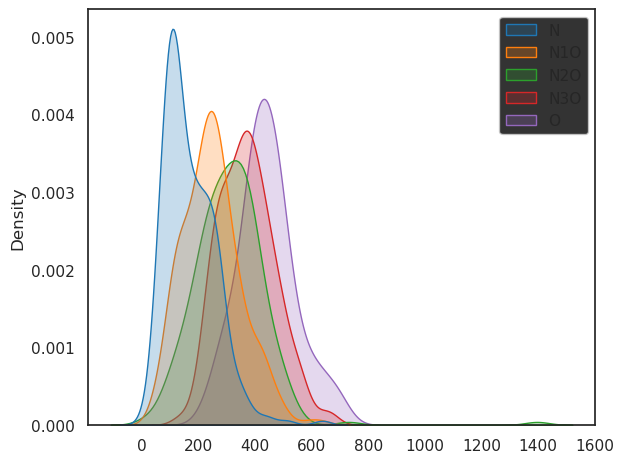

In [234]:
sns.kdeplot(dict({"N": n_mods, "N1O": n1o_mods, "N2O": n2o_mods,"N3O": n3o_mods,"O": o_mods}), 
            palette="tab10", common_norm=False, fill=True)#hue=[cmap(i) for i in [0,0.2,0.4,0.6,0.8]])
plt.tight_layout()
#plt.xscale("log")
#plt.xlim([50,5000])
#plt.ylim([0,0.004])

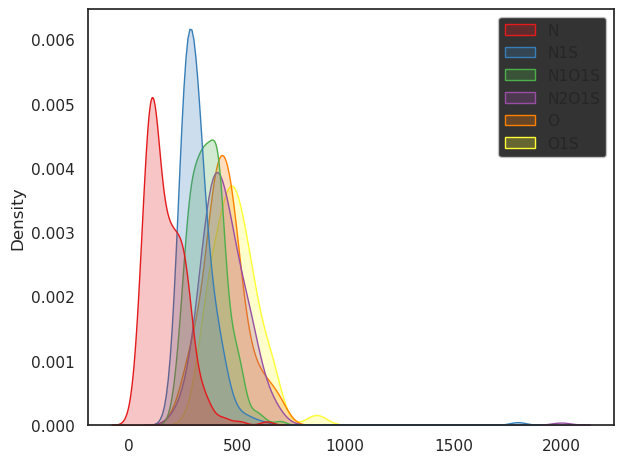

In [235]:
sns.kdeplot(dict({"N": n_mods, "N1S": n1s_mods, "N1O1S": n1o1s_mods,"N2O1S": n2o1s_mods,"O": o_mods,"O1S": o1s_mods}), 
            palette="Set1", common_norm=False, fill=True)#hue=[cmap(i) for i in [0,0.2,0.4,0.6,0.8]])
plt.tight_layout()
#plt.xscale("log")
#plt.xlim([50,5000])
#plt.ylim([0,0.004])

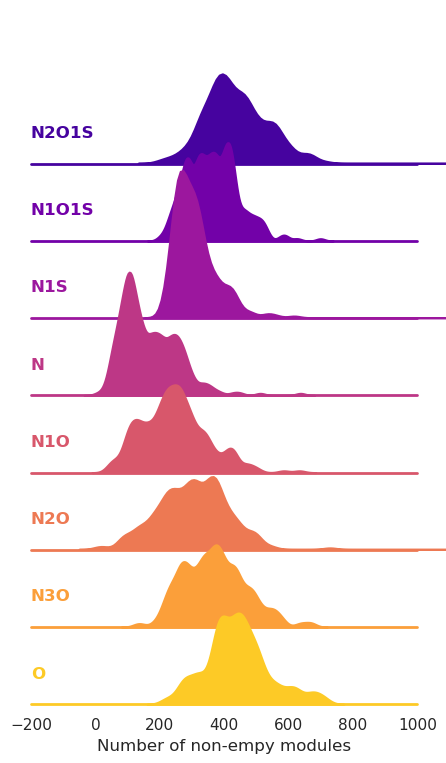

In [241]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = np.concatenate([["N2O1S"]*len(n2o1s_mods),
                    ["N1O1S"]*len(n1o1s_mods),
                    ["N1S"]*len(n1s_mods),
                    ["N"]*len(n_mods),
                   ["N1O"]*len(n1o_mods),
                   ["N2O"]*len(n2o_mods),
                   ["N3O"]*len(n3o_mods),
                   ["O"]*len(o_mods)])
                   
x = np.concatenate([n2o1s_mods, n1o1s_mods, n1s_mods, n_mods, n1o_mods, n2o_mods, n3o_mods, o_mods])
df = pd.DataFrame(dict(CompDim=x, g=g))
pal = ["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette="plasma")
g.map(sns.kdeplot, "CompDim",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    #ax.vlines(len(onco_lcc), 0 ,0.0018, ls="--", color="red")
g.map(label, "CompDim")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Number of non-empy modules", xlim=[-200,1000])
g.despine(bottom=True, left=True)

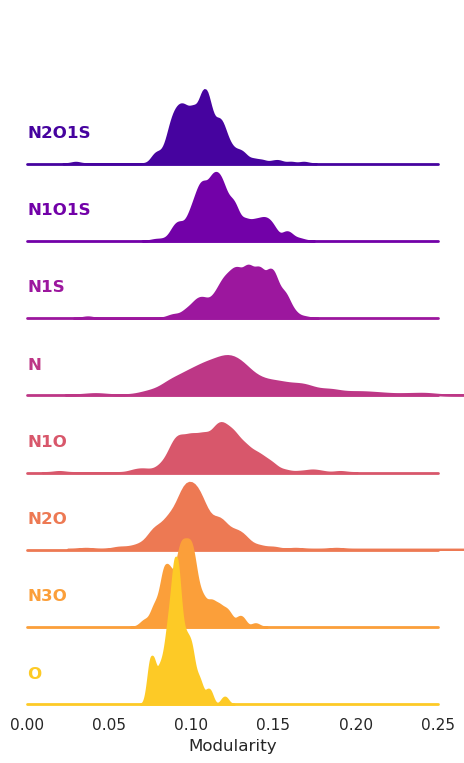

In [242]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = np.concatenate([["N2O1S"]*len(n2o1s_mody),
                    ["N1O1S"]*len(n1o1s_mody),
                    ["N1S"]*len(n1s_mody),
                    ["N"]*len(n_mody),
                   ["N1O"]*len(n1o_mody),
                   ["N2O"]*len(n2o_mody),
                   ["N3O"]*len(n3o_mody),
                   ["O"]*len(o_mody)])
                   
x = np.concatenate([n2o1s_mody, n1o1s_mody, n1s_mody, n_mody, n1o_mody, n2o_mody, n3o_mody, o_mody])
df = pd.DataFrame(dict(CompDim=x, g=g))
pal = ["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette="plasma")
g.map(sns.kdeplot, "CompDim",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    #ax.vlines(len(onco_lcc), 0 ,0.0018, ls="--", color="red")
g.map(label, "CompDim")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Modularity", xlim=[0,0.25])
g.despine(bottom=True, left=True)

In [363]:
labels = ["N2O1S", "N1O1S", "N1S", "N", "N1O", "N2O", "N3O", "O"]
mody_list = [n2o1s_mody, n1o1s_mody, n1s_mody, n_mody, n1o_mody, n2o_mody, n3o_mody, o_mody]
mods_list = [n2o1s_mods, n1o1s_mods, n1s_mods, n_mods, n1o_mods, n2o_mods, n3o_mods, o_mods]
M_mody = np.zeros([len(mody_list), len(mody_list)])
M_mods = np.zeros([len(mods_list), len(mods_list)])
for i in range(len(mody_list)):
    for j in range(len(mody_list)):
        M_mody[i,j] = sp.stats.ranksums(mody_list[i], mody_list[j])[0]
        M_mods[i,j] = sp.stats.ranksums(mods_list[i], mods_list[j])[0]
        #M_mody[i,j] = sp.stats.wasserstein_distance(mody_list[i], mody_list[j])
        #M_mods[i,j] = sp.stats.wasserstein_distance(mods_list[i], mods_list[j])
        #M_mody[i,j] = sp.stats.kstest(mody_list[i], mody_list[j]).statistic
        #M_mods[i,j] = sp.stats.kstest(mods_list[i], mods_list[j]).statistic

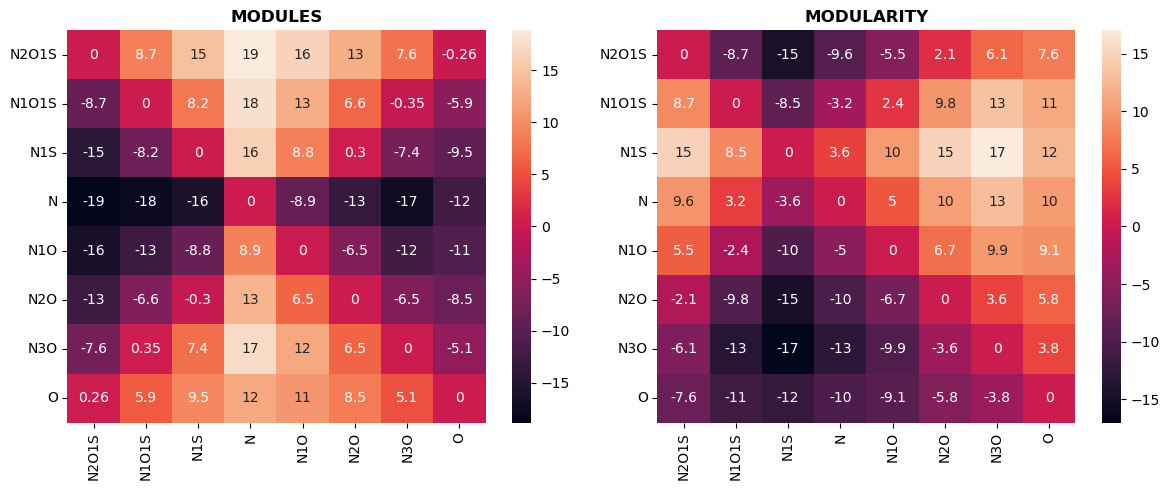

In [364]:
_, ax = plt.subplots(1,2,figsize=(12,5))
sns.heatmap(M_mody, annot=True, xticklabels=labels, yticklabels=labels, ax=ax[1])
ax[1].set_title("MODULARITY", fontweight="bold")
ax[1].set_yticklabels(labels, rotation=0)

sns.heatmap(M_mods, annot=True, xticklabels=labels, yticklabels=labels, ax=ax[0])
ax[0].set_title("MODULES", fontweight="bold")
ax[0].set_yticklabels(labels, rotation=0)
plt.tight_layout()

In [317]:
indd = np.random.choice(np.arange(len(n_mody)),150,replace=False)

In [334]:
mods_fit = np.concatenate([o_mods,o1s_mods,n_mods[indd],n1o_mods[indd],n2o_mods[indd],n3o_mods[indd],n1s_mods[indd],n1o1s_mods[indd],n2o1s_mods[indd]])
lcc_fit = np.concatenate([o_lcc,o1s_lcc,n_lcc[indd],n1o_lcc[indd],n2o_lcc[indd],n3o_lcc[indd],n1s_lcc[indd],n1o1s_lcc[indd],n2o1s_lcc[indd]])
mody_fit = np.concatenate([o_mody,o1s_mody,n_mody[indd],n1o_mody[indd],n2o_mody[indd],n3o_mody[indd],n1s_mody[indd],n1o1s_mody[indd],n2o1s_mody[indd]])

Text(0.5, 1.0, 'MODULARITY')

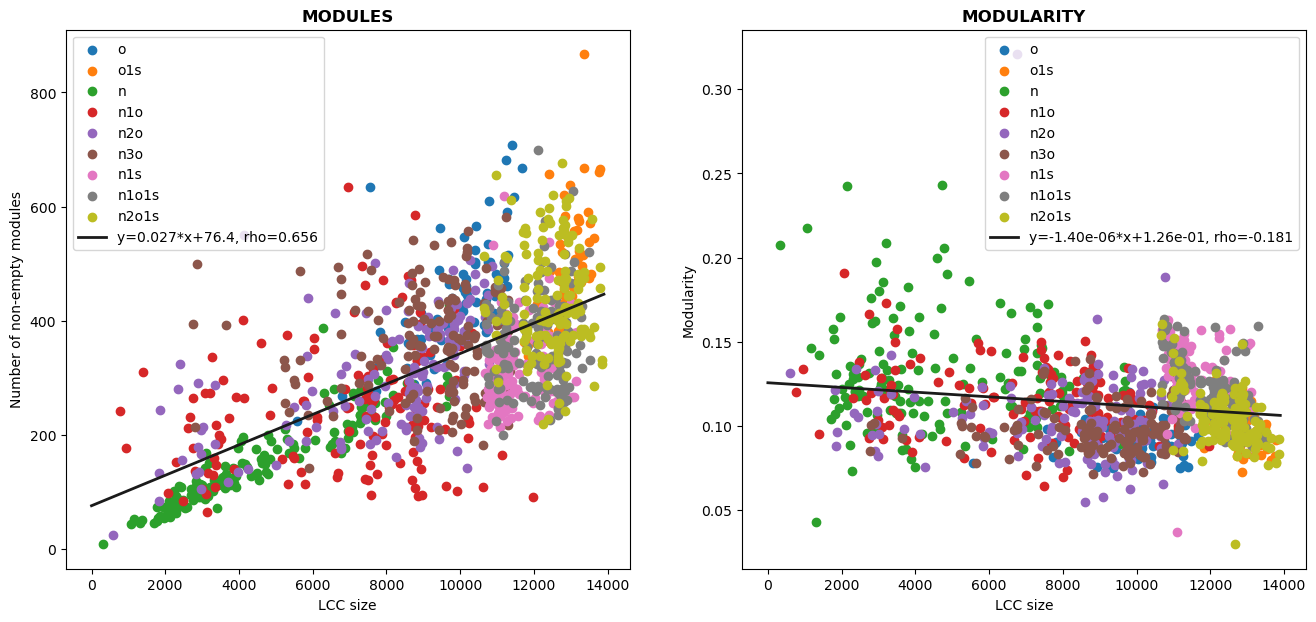

In [362]:
plt.rcdefaults()
_, ax = plt.subplots(1,2, figsize=(16,7))

mods_slope, mods_intercept = np.polyfit(lcc_fit, mods_fit, 1)
mods_coeff = np.corrcoef(lcc_fit, mods_fit)[0,1]
ax[0].scatter(o_lcc, o_mods, label="o")
ax[0].scatter(o1s_lcc, o1s_mods, label="o1s")
ax[0].scatter(n_lcc[indd], n_mods[indd], label="n")
ax[0].scatter(n1o_lcc[indd], n1o_mods[indd], label="n1o")
ax[0].scatter(n2o_lcc[indd], n2o_mods[indd], label="n2o")
ax[0].scatter(n3o_lcc[indd], n3o_mods[indd], label="n3o")
ax[0].scatter(n1s_lcc[indd], n1s_mods[indd], label="n1s")
ax[0].scatter(n1o1s_lcc[indd], n1o1s_mods[indd], label="n1o1s")
ax[0].scatter(n2o1s_lcc[indd], n2o1s_mods[indd], label="n2o1s")
ax[0].plot(np.arange(0,14000,100), np.arange(0,14000,100)*mods_slope+mods_intercept, color="k", lw=2, label="y=%.3f*x+%.1f, rho=%.3f" %(mods_slope, mods_intercept, mods_coeff))
ax[0].legend()
ax[0].set_xlabel("LCC size")
ax[0].set_ylabel("Number of non-empty modules")
ax[0].set_title("MODULES", fontweight="bold")

mody_slope, mody_intercept = np.polyfit(lcc_fit, mody_fit, 1)
mody_coeff = np.corrcoef(lcc_fit, mody_fit)[0,1]
ax[1].scatter(o_lcc, o_mody, label="o")
ax[1].scatter(o1s_lcc, o1s_mody, label="o1s")
ax[1].scatter(n_lcc[indd], n_mody[indd], label="n")
ax[1].scatter(n1o_lcc[indd], n1o_mody[indd], label="n1o")
ax[1].scatter(n2o_lcc[indd], n2o_mody[indd], label="n2o")
ax[1].scatter(n3o_lcc[indd], n3o_mody[indd], label="n3o")
ax[1].scatter(n1s_lcc[indd], n1s_mody[indd], label="n1s")
ax[1].scatter(n1o1s_lcc[indd], n1o1s_mody[indd], label="n1o1s")
ax[1].scatter(n2o1s_lcc[indd], n2o1s_mody[indd], label="n2o1s")
ax[1].plot(np.arange(0,14000,100), np.arange(0,14000,100)*mody_slope+mody_intercept, color="k", lw=2, label="y=%.2e*x+%.2e, rho=%.3f" %(mody_slope, mody_intercept, mody_coeff))
ax[1].legend()
ax[1].set_xlabel("LCC size")
ax[1].set_ylabel("Modularity")
ax[1].set_title("MODULARITY", fontweight="bold")

# Perc

In [22]:
o_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/o.txt")

n_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n.txt")

n1o_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n1o.txt")

n2o_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n2o.txt")

n3o_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n3o.txt")

n1s_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n1s.txt")

n1o1s_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n1o1s.txt")

n2o1s_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n2o1s.txt")

o1s_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/o1s.txt")

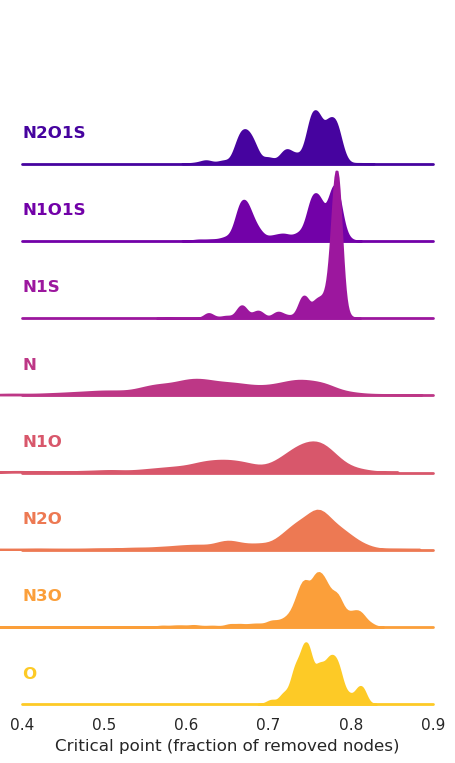

In [531]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = np.concatenate([["N2O1S"]*len(n2o1s_perc),
                    ["N1O1S"]*len(n1o1s_perc),
                    ["N1S"]*len(n1s_perc),
                    ["N"]*len(n_perc),
                   ["N1O"]*len(n1o_perc),
                   ["N2O"]*len(n2o_perc),
                   ["N3O"]*len(n3o_perc),
                   ["O"]*len(o_perc)])
                   
x = np.concatenate([n2o1s_perc, n1o1s_perc, n1s_perc, n_perc, n1o_perc, n2o_perc, n3o_perc, o_perc])
df = pd.DataFrame(dict(CompDim=x, g=g))
pal = ["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette="plasma")
g.map(sns.kdeplot, "CompDim",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5, common_norm=True)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    #ax.vlines(len(onco_lcc), 0 ,0.0018, ls="--", color="red")
g.map(label, "CompDim")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Critical point (fraction of removed nodes)", xlim=[0.4,0.9])
g.despine(bottom=True, left=True)

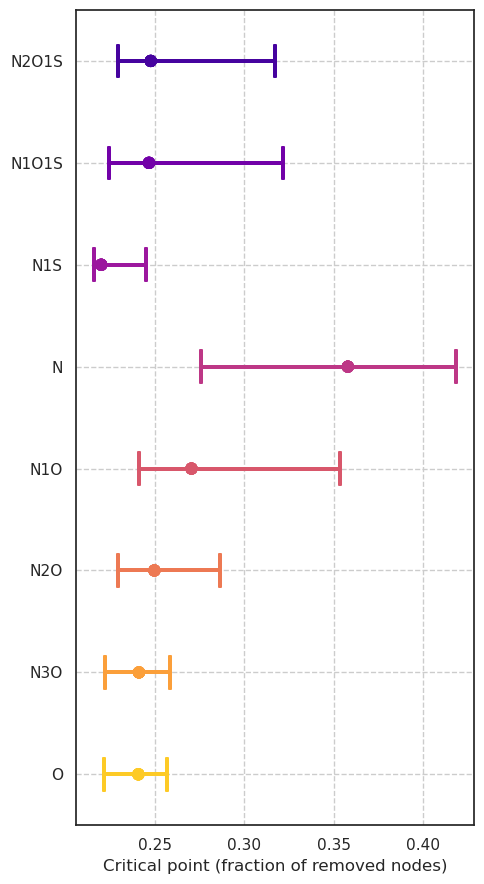

In [508]:
plt.figure(figsize=(5,9))
for i in range(len(med_list)):
    sns.pointplot(data = {"lab": np.concatenate([[i]*len(perc_list[i]) for i in range(len(perc_list))]), "med":np.concatenate(perc_list)}, 
                  y = "lab",
                  x="med", 
                  errorbar=("pi",50), linestyles="", palette="plasma", estimator="median", capsize=0.3, orient="horizontal")
    #plt.errorbar(x=i, y=med_list[i], yerr=std_list[i], capsize=10, lw=0, elinewidth=2, c=plt.cm.plasma(i/8))
    #plt.scatter(i, med_list[i], s=50, color=plt.cm.plasma(i/8))
plt.yticks(np.arange(len(med_list)), labels=labels)
plt.xlabel("Critical point (fraction of removed nodes)")
plt.grid(ls="--")
plt.tight_layout()

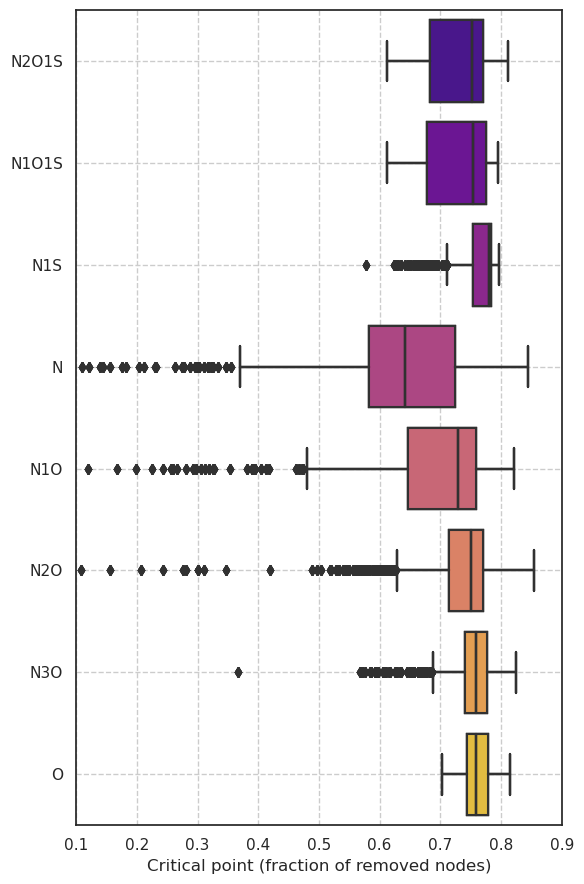

In [529]:
plt.figure(figsize=(6,9))
for i in range(len(med_list)):
    sns.boxplot(data = {"lab": np.concatenate([[i]*len(perc_list[i]) for i in range(len(perc_list))]), "med":np.concatenate(perc_list)}, 
                  y = "lab",
                  x = "med", 
                  palette="plasma", orient="horizontal")
    #plt.errorbar(x=i, y=med_list[i], yerr=std_list[i], capsize=10, lw=0, elinewidth=2, c=plt.cm.plasma(i/8))
    #plt.scatter(i, med_list[i], s=50, color=plt.cm.plasma(i/8))
plt.yticks(np.arange(len(med_list)), labels=labels)
plt.xlabel("Critical point (fraction of removed nodes)")
plt.xlim([0.1,0.9])
plt.grid(ls="--")
plt.tight_layout()

In [528]:
labels = ["N2O1S", "N1O1S", "N1S", "N", "N1O", "N2O", "N3O", "O"]
perc_list = [n2o1s_perc, n1o1s_perc, n1s_perc, n_perc, n1o_perc, n2o_perc, n3o_perc, o_perc]
M_perc = np.zeros([len(perc_list), len(perc_list)])

for i in range(len(mody_list)):
    for j in range(len(mody_list)):
        M_perc[i,j] = -np.log10(sp.stats.ranksums(perc_list[i], perc_list[j]).pvalue)
        #M_perc[i,j] = sp.stats.wasserstein_distance(perc_list[i], perc_list[j])
        #M_perc[i,j] = sp.stats.kstest(perc_list[i], perc_list[j]).statistic

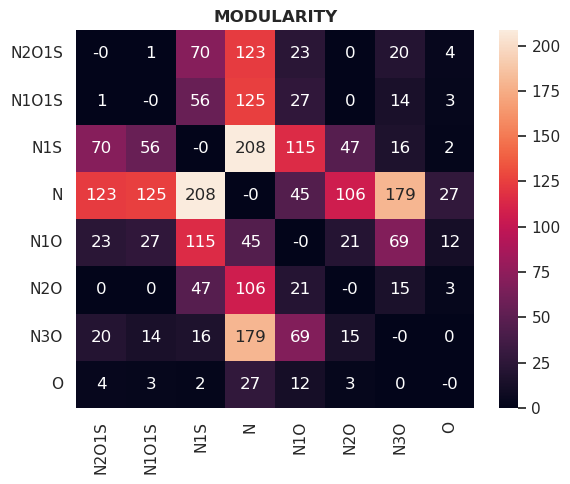

In [521]:
_, ax = plt.subplots(1,1,figsize=(6,5))
sns.heatmap(M_perc, annot=True, xticklabels=labels, yticklabels=labels, ax=ax, fmt=".0f")
ax.set_title("MODULARITY", fontweight="bold")
ax.set_xticklabels(labels, rotation=90)
plt.tight_layout()

# Features separation

In [15]:
len(n_mody)

259

In [68]:
min([len(n1s_lcc),len(n1s_lic),len(n1s_lvc),len(n1s_mods),len(n1s_mody),len(n1s_perc)])

258

In [343]:
o_data = []
for m in [o_lcc,o_lic,o_lvc,o_mods,o_mody,o_perc]:
    o_data.append(m[:70])
o_data =np.array(o_data)
print(o_data.shape)

n_data = []
for m in [n_lcc,n_lic,n_lvc,n_mods,n_mody,n_perc]:
    n_data.append(m[:256])
n_data =np.array(n_data)
print(n_data.shape)

n1s_data = []
for m in [n1s_lcc,n1s_lic,n1s_lvc,n1s_mods,n1s_mody,n1s_perc]:
    n1s_data.append(m[:256])
n1s_data =np.array(n1s_data)
print(n1s_data.shape)

n1o_data = []
for m in [n1o_lcc,n1o_lic,n1o_lvc,n1o_mods,n1o_mody,n1o_perc]:
    n1o_data.append(m[:256])
n1o_data =np.array(n1o_data)
print(n1o_data.shape)

n2o_data = []
for m in [n2o_lcc,n2o_lic,n2o_lvc,n2o_mods,n2o_mody,n2o_perc]:
    n2o_data.append(m[:256])
n2o_data =np.array(n2o_data)
print(n2o_data.shape)

n3o_data = []
for m in [n3o_lcc,n3o_lic,n3o_lvc,n3o_mods,n3o_mody,n3o_perc]:
    n3o_data.append(m[:256])
n3o_data =np.array(n3o_data)
print(n3o_data.shape)

o1s_data = []
for m in [o1s_lcc,o1s_lic,o1s_lvc,o1s_mods,o1s_mody,o1s_perc]:
    o1s_data.append(m[:56])
o1s_data =np.array(o1s_data)
print(o1s_data.shape)

n1o1s_data = []
for m in [n1o1s_lcc,n1o1s_lic,n1o1s_lvc,n1o1s_mods,n1o1s_mody,n1o1s_perc]:
    n1o1s_data.append(m[:256])
n1o1s_data =np.array(n1o1s_data)
print(n1o1s_data.shape)

n2o1s_data = []
for m in [n2o1s_lcc,n2o1s_lic,n2o1s_lvc,n2o1s_mods,n2o1s_mody,n2o1s_perc]:
    n2o1s_data.append(m[:256])
n2o1s_data =np.array(n2o1s_data)
print(n2o1s_data.shape)


(6, 70)
(6, 256)
(6, 256)
(6, 256)
(6, 256)
(6, 256)
(6, 56)
(6, 256)
(6, 256)


In [372]:
import umap
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [304]:
comb = list(itertools.combinations(range(6), 3))

for i in range(len(comb)):
    reducer = umap.UMAP(random_state=42)
    data_all = np.concatenate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data],axis=1).T
    embedding = reducer.fit_transform(data_all[:,comb[i]])

    # Generate non-linearly separable data
    X = embedding[:70+256]
    y = np.concatenate([[0]*70,[1]*256])

    # Create an SVM classifier with RBF kernel
    classifier = SVC(kernel='rbf')

    # Train the classifier
    classifier.fit(X, y)
    print(comb[i])
    print(classifier.predict(embedding[0:70]).mean(),classifier.predict(embedding[70:256+70]).mean())

(0, 1, 2)
0.18571428571428572 0.921875
(0, 1, 3)
0.14285714285714285 0.921875
(0, 1, 4)
0.15714285714285714 0.921875
(0, 1, 5)
0.2 0.921875
(0, 2, 3)
0.14285714285714285 0.921875
(0, 2, 4)
0.15714285714285714 0.921875
(0, 2, 5)
0.2 0.921875
(0, 3, 4)
0.12857142857142856 0.91796875
(0, 3, 5)
0.12857142857142856 0.921875
(0, 4, 5)
0.11428571428571428 0.91796875
(1, 2, 3)
0.08571428571428572 0.9609375
(1, 2, 4)
0.9285714285714286 0.99609375
(1, 2, 5)
0.9142857142857143 0.99609375
(1, 3, 4)
0.15714285714285714 0.95703125
(1, 3, 5)
0.2 0.95703125
(1, 4, 5)
1.0 1.0
(2, 3, 4)
0.15714285714285714 0.95703125
(2, 3, 5)
0.2 0.95703125
(2, 4, 5)
1.0 1.0
(3, 4, 5)
0.8142857142857143 0.99609375


In [348]:
comb = list(itertools.combinations(range(6), 4))

for i in range(len(comb)):
    reducer = umap.UMAP(random_state=42)
    data_all = np.concatenate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data, n1o1s_data, n2o1s_data],axis=1).T
    embedding = reducer.fit_transform(data_all[:,comb[i]])

    # Generate non-linearly separable data
    X = embedding[:70+256]
    y = np.concatenate([[0]*70,[1]*256])

    # Create an SVM classifier with RBF kernel
    classifier = SVC(kernel='rbf')

    # Train the classifier
    classifier.fit(X, y)
    print(comb[i])
    print(classifier.predict(embedding[0:70]).mean(),classifier.predict(embedding[70:256+70]).mean())

(0, 1, 2, 3)
0.14285714285714285 0.9140625
(0, 1, 2, 4)
0.14285714285714285 0.921875
(0, 1, 2, 5)
0.11428571428571428 0.9140625
(0, 1, 3, 4)
0.18571428571428572 0.921875
(0, 1, 3, 5)
0.2 0.921875
(0, 1, 4, 5)
0.14285714285714285 0.921875
(0, 2, 3, 4)
0.18571428571428572 0.921875
(0, 2, 3, 5)
0.2 0.921875
(0, 2, 4, 5)
0.14285714285714285 0.921875
(0, 3, 4, 5)
0.12857142857142856 0.921875
(1, 2, 3, 4)
0.08571428571428572 0.9609375
(1, 2, 3, 5)
0.1 0.9609375
(1, 2, 4, 5)
0.5 0.9375
(1, 3, 4, 5)
0.14285714285714285 0.953125
(2, 3, 4, 5)
0.14285714285714285 0.953125


In [306]:
comb = list(itertools.combinations(range(6), 5))

for i in range(len(comb)):
    reducer = umap.UMAP(random_state=42)
    data_all = np.concatenate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data],axis=1).T
    embedding = reducer.fit_transform(data_all[:,comb[i]])

    # Generate non-linearly separable data
    X = embedding[:70+256]
    y = np.concatenate([[0]*70,[1]*256])

    # Create an SVM classifier with RBF kernel
    classifier = SVC(kernel='rbf')

    # Train the classifier
    classifier.fit(X, y)
    print(comb[i])
    print(classifier.predict(embedding[0:70]).mean(),classifier.predict(embedding[70:256+70]).mean())

(0, 1, 2, 3, 4)
0.12857142857142856 0.9140625
(0, 1, 2, 3, 5)
0.14285714285714285 0.9140625
(0, 1, 2, 4, 5)
0.14285714285714285 0.93359375
(0, 1, 3, 4, 5)
0.17142857142857143 0.921875
(0, 2, 3, 4, 5)
0.17142857142857143 0.921875
(1, 2, 3, 4, 5)
0.08571428571428572 0.9609375


In [378]:
X = data_all[:70+256,2:]
y = np.concatenate([[0]*70,[1]*256])
# Create an SVM classifier with RBF kernel
classifier = SVC(kernel='rbf')

# Train the classifier
classifier.fit(X, y)

SVC()

In [382]:
classifier.decision_function(X)

array([-0.99980858, -1.01686061, -1.00073103, -0.2839338 , -1.11400647,
       -1.00010984, -1.0071595 , -0.32111152, -1.13285584, -1.00456101,
       -0.76606244, -1.04271564,  0.57383528, -1.02776925, -0.1304076 ,
       -0.9998086 , -1.00189029, -1.00012094, -1.13389337, -0.99984067,
       -1.57535859, -1.11230102, -0.06317046, -1.29333791,  0.05635575,
       -1.00260071, -1.15226824, -1.11210263,  0.49965865, -1.41262855,
       -0.69961532, -0.0187573 , -1.07614922, -0.20548993,  0.821243  ,
       -1.00336771, -1.00869456, -0.15519867, -1.10998661, -1.00356919,
       -0.36284082, -1.22464891,  0.77236033, -0.98788238,  0.39571221,
       -1.00914965, -0.89996751, -1.01496918, -0.11826981, -0.89343694,
        0.57542016,  0.88287522, -1.0000985 ,  0.5323847 ,  1.3053165 ,
       -1.0000986 , -1.23132078, -1.11689661,  0.03357978, -1.32809279,
       -0.37320879, -0.46499759, -1.27433525, -0.38140956,  1.01821481,
        0.12874076, -1.16701544,  0.15908239, -1.71320991,  0.97

In [379]:
accuracy_score(classifier.predict(X),y)

0.9325153374233128

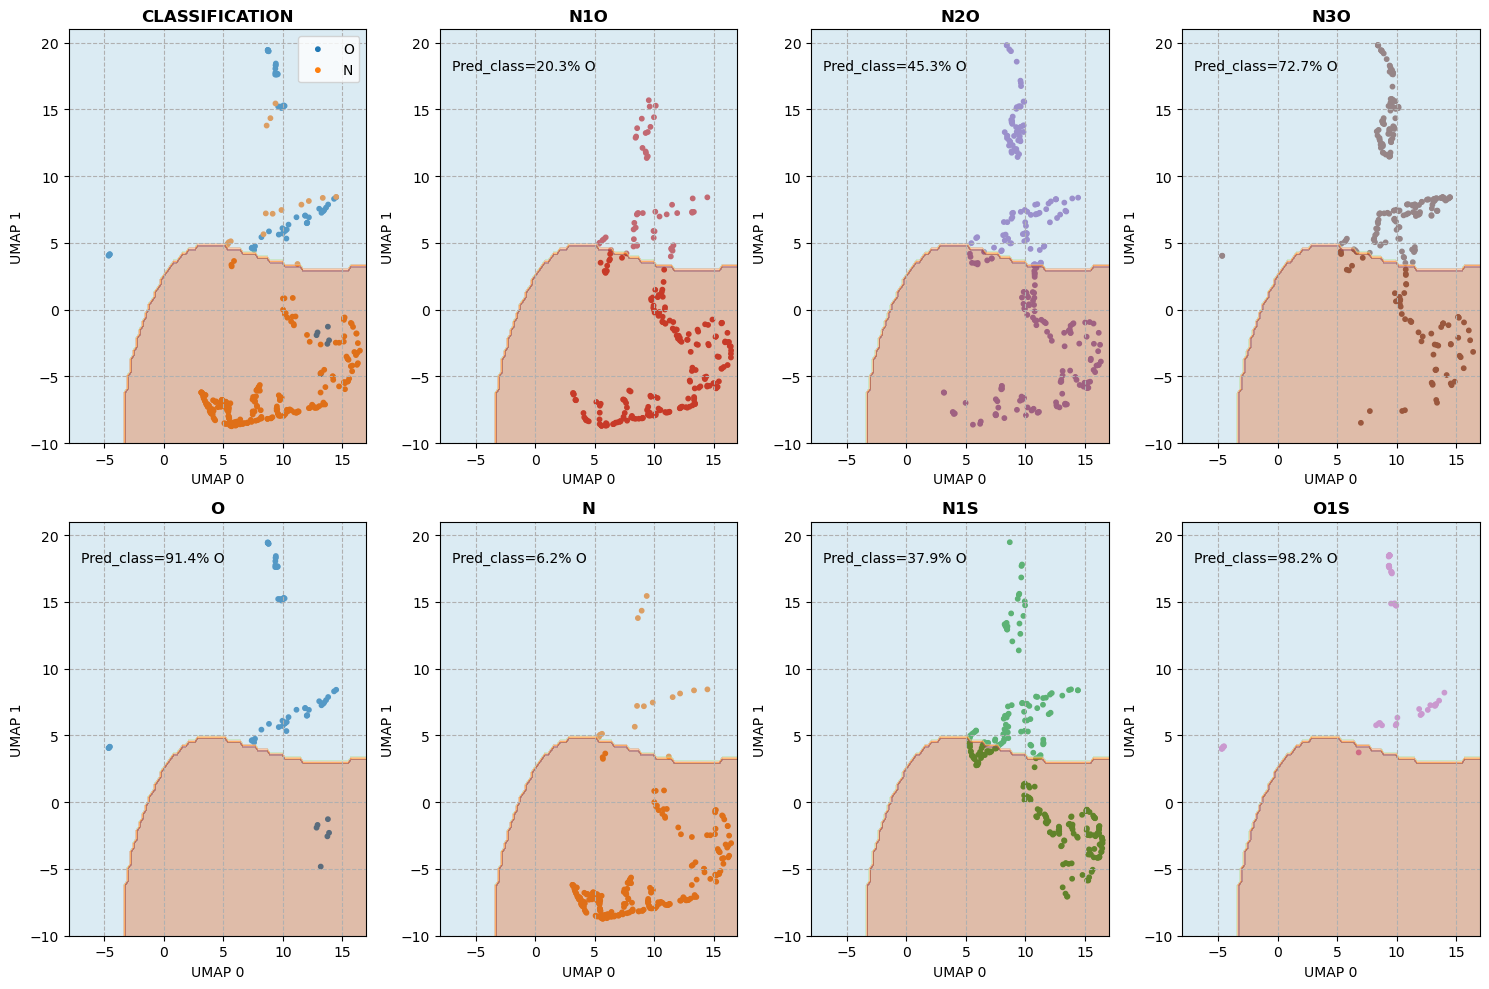

In [362]:
reducer = umap.UMAP(random_state=42)
data_all = np.concatenate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data],axis=1).T
embedding = reducer.fit_transform(data_all[:,[1,3,4,5]])

# Generate non-linearly separable data
X = embedding[:70+256]
y = np.concatenate([[0]*70,[1]*256])

# Create an SVM classifier with RBF kernel
classifier = SVC(kernel='rbf')

# Train the classifier
classifier.fit(X, y)

# Plot the points and their true labels

# Create a meshgrid to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(-8, 17, 100),
                     np.linspace(-10, 21, 100))

# Predict the labels for the meshgrid points
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted labels to match the meshgrid shape
Z = Z.reshape(xx.shape)

_, ax = plt.subplots(2,4,figsize=(15,10))
ax = ax.flatten()

clist = [[plt.cm.tab10(i)]*len(n.T) for i,n in enumerate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data])]
clist = np.concatenate(clist)

lens = [len(n.T) for n in ([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data])]
limlist = np.concatenate([[0], np.cumsum(lens)])
labels=["O","N","N1S", "N1O", "N2O", "N3O", "O1S", "N1O1S", "N2O1S"]
ax[0].scatter(embedding[limlist[0]:limlist[1],0],embedding[limlist[0]:limlist[1],1], c=clist[limlist[0]:limlist[1]], s=10, label="O")
ax[0].scatter(embedding[limlist[1]:limlist[2],0],embedding[limlist[1]:limlist[2],1], c=clist[limlist[1]:limlist[2]], s=10, label="N")
ax[0].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
ax_list = [4,5,6,1,2,3,7]

for i in range(len(limlist)-1):
    ax[ax_list[i]].scatter(embedding[limlist[i]:limlist[i+1],0],embedding[limlist[i]:limlist[i+1],1], c=clist[limlist[i]:limlist[i+1]], s=10)
    ax[ax_list[i]].set_title(labels[i], fontweight="bold")
    ax[ax_list[i]].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
    ax[ax_list[i]].text(-7,18,"Pred_class="+str(np.round((1-classifier.predict(embedding[limlist[i]:limlist[i+1]]).mean())*100,1))+"% O")
[ax[i].set_xlim([-8,17]) for i in range(len(lens)+1)]
[ax[i].set_ylim([-10,21]) for i in range(len(lens)+1)]
[ax[i].set_xlabel("UMAP 0") for i in range(len(lens)+1)]
[ax[i].set_ylabel("UMAP 1") for i in range(len(lens)+1)]
[ax[i].grid(ls="--") for i in range(len(lens)+1)]
ax[0].set_title("CLASSIFICATION", fontweight="bold")
ax[0].legend()
plt.tight_layout()

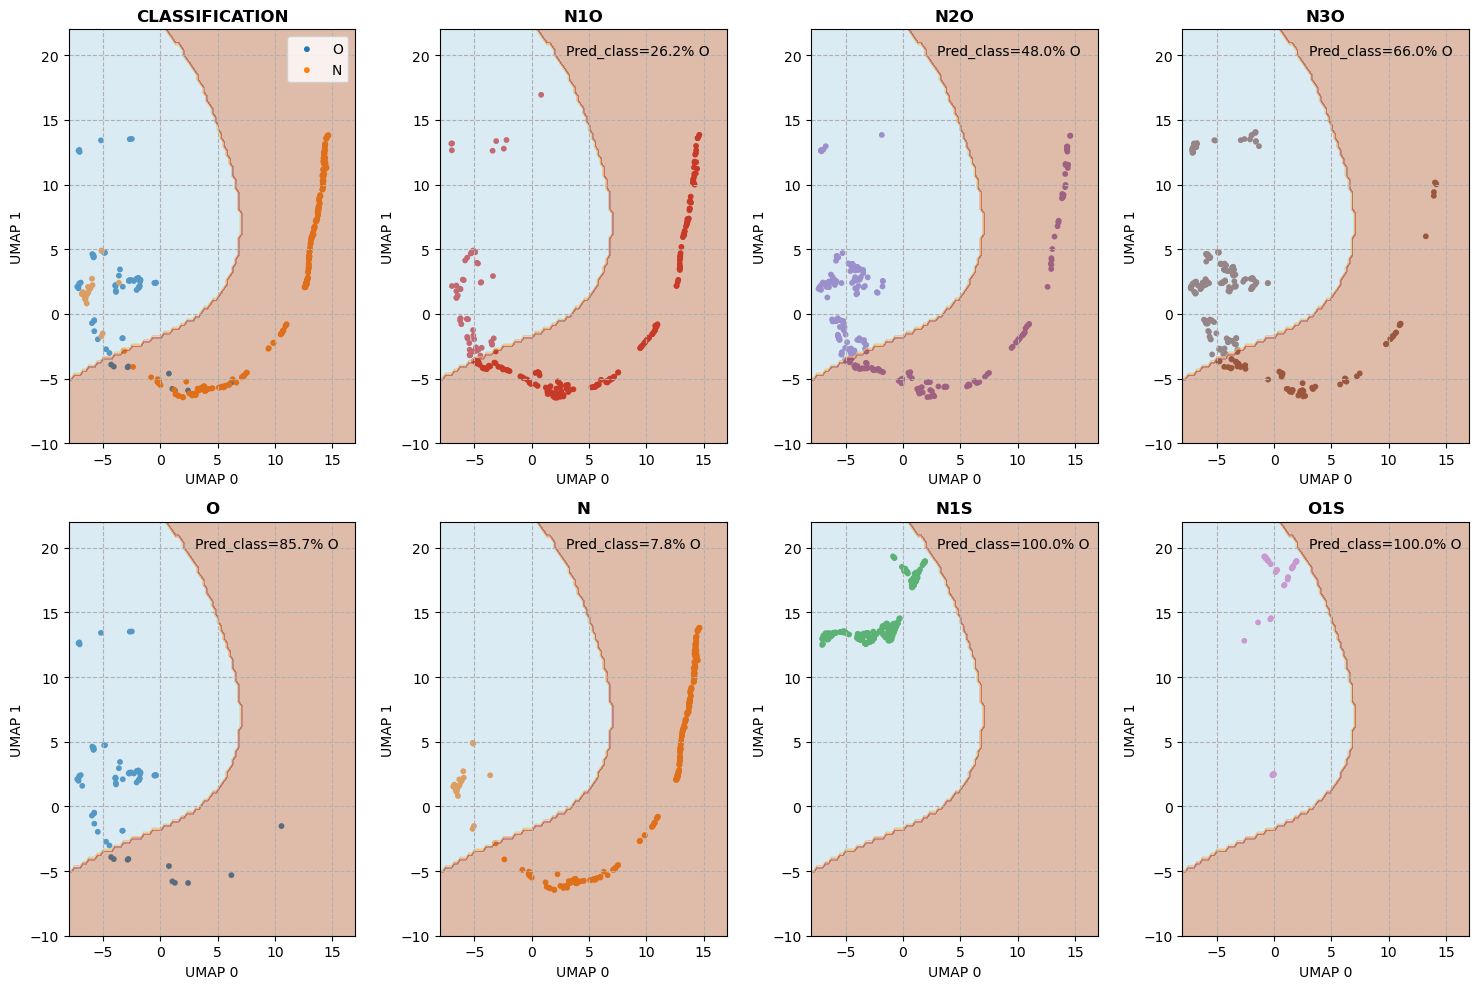

In [364]:
reducer = umap.UMAP(random_state=42)
data_all = np.concatenate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data],axis=1).T
embedding = reducer.fit_transform(data_all[:,[0,1,2,3,4,5]])

# Generate non-linearly separable data
X = embedding[:70+256]
y = np.concatenate([[0]*70,[1]*256])

# Create an SVM classifier with RBF kernel
classifier = SVC(kernel='rbf')

# Train the classifier
classifier.fit(X, y)

# Plot the points and their true labels

# Create a meshgrid to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(-8, 17, 100),
                     np.linspace(-10, 22, 100))

# Predict the labels for the meshgrid points
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted labels to match the meshgrid shape
Z = Z.reshape(xx.shape)

_, ax = plt.subplots(2,4,figsize=(15,10))
ax = ax.flatten()

clist = [[plt.cm.tab10(i)]*len(n.T) for i,n in enumerate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data])]
clist = np.concatenate(clist)

lens = [len(n.T) for n in ([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data])]
limlist = np.concatenate([[0], np.cumsum(lens)])
labels=["O","N","N1S", "N1O", "N2O", "N3O", "O1S", "N1O1S", "N2O1S"]
ax[0].scatter(embedding[limlist[0]:limlist[1],0],embedding[limlist[0]:limlist[1],1], c=clist[limlist[0]:limlist[1]], s=10, label="O")
ax[0].scatter(embedding[limlist[1]:limlist[2],0],embedding[limlist[1]:limlist[2],1], c=clist[limlist[1]:limlist[2]], s=10, label="N")
ax[0].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
ax_list = [4,5,6,1,2,3,7]

for i in range(len(limlist)-1):
    ax[ax_list[i]].scatter(embedding[limlist[i]:limlist[i+1],0],embedding[limlist[i]:limlist[i+1],1], c=clist[limlist[i]:limlist[i+1]], s=10)
    ax[ax_list[i]].set_title(labels[i], fontweight="bold")
    ax[ax_list[i]].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
    ax[ax_list[i]].text(3,20,"Pred_class="+str(np.round((1-classifier.predict(embedding[limlist[i]:limlist[i+1]]).mean())*100,1))+"% O")
[ax[i].set_xlim([-8,17]) for i in range(len(lens)+1)]
[ax[i].set_ylim([-10,22]) for i in range(len(lens)+1)]
[ax[i].set_xlabel("UMAP 0") for i in range(len(lens)+1)]
[ax[i].set_ylabel("UMAP 1") for i in range(len(lens)+1)]
[ax[i].grid(ls="--") for i in range(len(lens)+1)]
ax[0].set_title("CLASSIFICATION", fontweight="bold")
ax[0].legend()
plt.tight_layout()

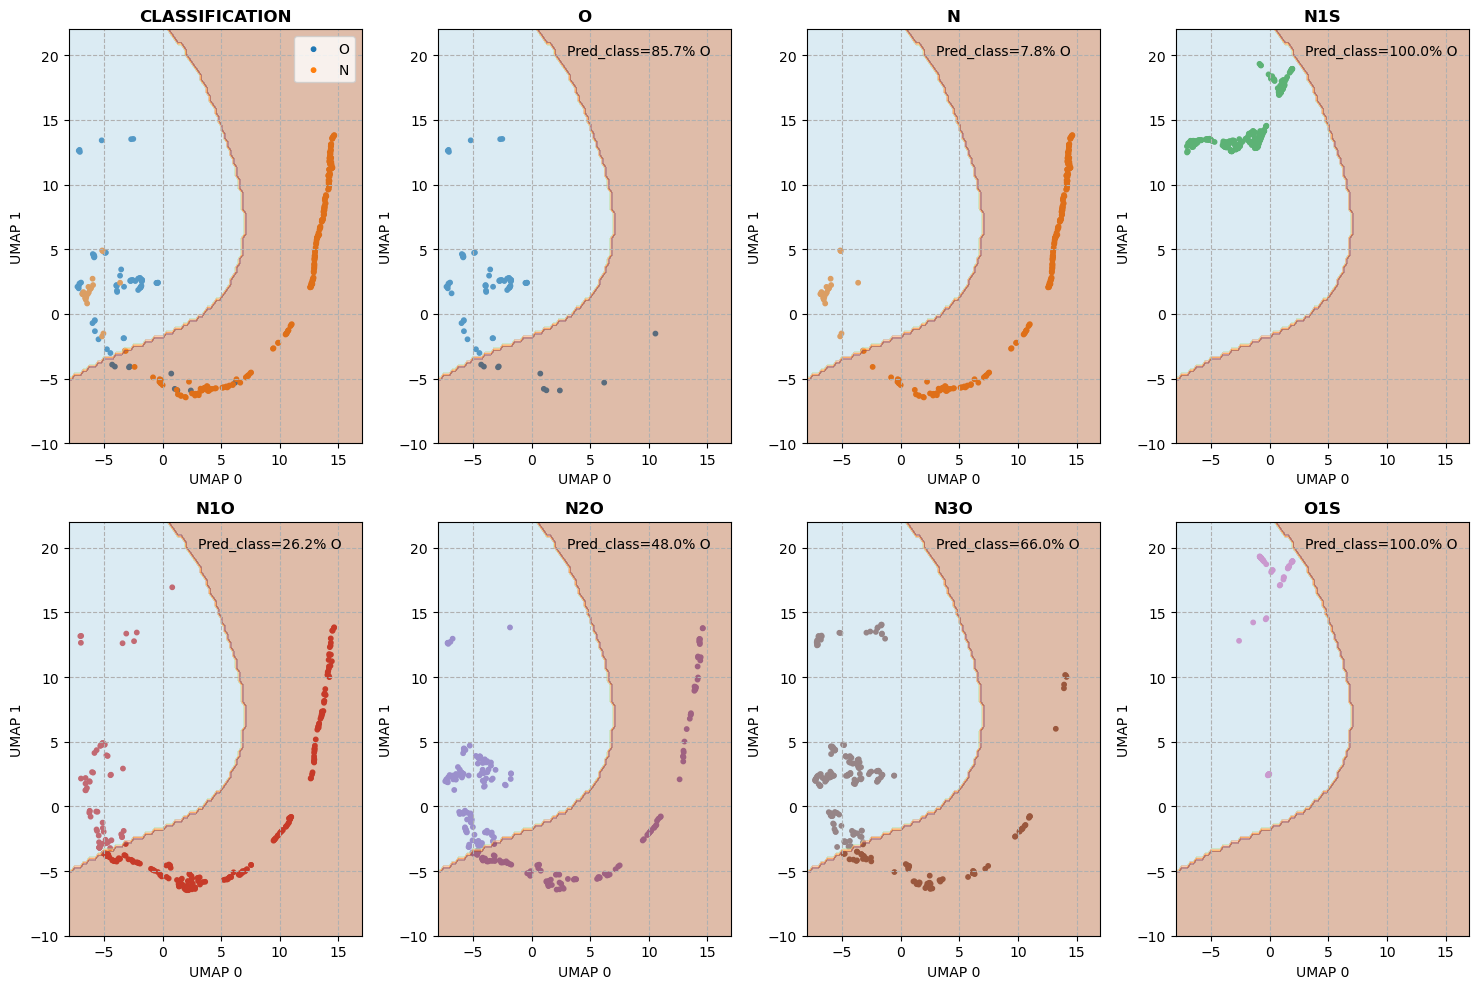

In [342]:
reducer = umap.UMAP(random_state=42)
data_all = np.concatenate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data],axis=1).T
embedding = reducer.fit_transform(data_all[:,[0,1,2,3,4,5]])

# Generate non-linearly separable data
X = embedding[:70+256]
y = np.concatenate([[0]*70,[1]*256])

# Create an SVM classifier with RBF kernel
classifier = SVC(kernel='rbf')

# Train the classifier
classifier.fit(X, y)

# Plot the points and their true labels

# Create a meshgrid to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(-8, 17, 100),
                     np.linspace(-10, 22, 100))

# Predict the labels for the meshgrid points
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted labels to match the meshgrid shape
Z = Z.reshape(xx.shape)

_, ax = plt.subplots(2,4,figsize=(15,10))
ax = ax.flatten()

clist = [[plt.cm.tab10(i)]*len(n.T) for i,n in enumerate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data])]
clist = np.concatenate(clist)

lens = [len(n.T) for n in ([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data])]
limlist = np.concatenate([[0], np.cumsum(lens)])
labels=["O","N","N1S", "N1O", "N2O", "N3O", "O1S"]
ax[0].scatter(embedding[limlist[0]:limlist[1],0],embedding[limlist[0]:limlist[1],1], c=clist[limlist[0]:limlist[1]], s=10, label="O")
ax[0].scatter(embedding[limlist[1]:limlist[2],0],embedding[limlist[1]:limlist[2],1], c=clist[limlist[1]:limlist[2]], s=10, label="N")
ax[0].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)

for i in range(len(limlist)-1):
    ax[i+1].scatter(embedding[limlist[i]:limlist[i+1],0],embedding[limlist[i]:limlist[i+1],1], c=clist[limlist[i]:limlist[i+1]], s=10)
    ax[i+1].set_title(labels[i], fontweight="bold")
    ax[i+1].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
    ax[i+1].text(3,20,"Pred_class="+str(np.round((1-classifier.predict(embedding[limlist[i]:limlist[i+1]]).mean())*100,1))+"% O")
[ax[i].set_xlim([-8,17]) for i in range(len(lens)+1)]
[ax[i].set_ylim([-10,22]) for i in range(len(lens)+1)]
[ax[i].set_xlabel("UMAP 0") for i in range(len(lens)+1)]
[ax[i].set_ylabel("UMAP 1") for i in range(len(lens)+1)]
[ax[i].grid(ls="--") for i in range(len(lens)+1)]
ax[0].set_title("CLASSIFICATION", fontweight="bold")
ax[0].legend()
plt.tight_layout()